In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns

## Util functions to transform and visualize cells 

In [2]:
class Args:
    """
    Class to convert a dictionary into an object, allowing attribute-style access.

    Attributes:
        dictionary (dict): The dictionary to be converted into an object.
    """

    def __init__(self, dictionary):
        """
        Initializes the Args object with the provided dictionary.

        Parameters:
            dictionary (dict): The dictionary to be converted into an object.
        """
        self.__dict__ = dictionary

    def __getattr__(self, key):
        """
        Allows attribute-style access to dictionary values.

        Parameters:
            key (str): The key corresponding to the attribute being accessed.

        Returns:
            Any: The value associated with the key in the dictionary.

        Raises:
            AttributeError: If the key does not exist in the dictionary.
        """
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        """
        Allows calling the object to retrieve dictionary values.

        Parameters:
            key (str): The key corresponding to the attribute being accessed.

        Returns:
            Any: The value associated with the key in the dictionary.
        """
        return self.__getattr__(key)


def t2np(t, batch_dim=False):
    """
    Convert a PyTorch tensor to a NumPy array and normalize pixel values.

    Parameters:
        t (torch.Tensor): The PyTorch tensor to be converted.

    Returns:
        numpy.ndarray: The NumPy array representation of the tensor.
    """
    if not batch_dim:
        return ((t.permute(1, 2, 0) + 1) / 2).clamp(0, 1).cpu().numpy()
    else: 
        return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def plot_n_images(images, n_to_plot, size=((1.5, 1.5))):
    """
    Plot a specified number of images from a list of images.

    Parameters:
        images (list): A list containing image data.
        n_to_plot (int): The number of images to plot.
        size (tuple): The size of each plot (optional).

    Returns:
        None
    """
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        plt.imshow(img)
        plt.show()
        if i == n_to_plot:
            break

def euclidean_distance(A, B):
    """
    Compute the Euclidean distance between all pairs of rows of matrices A and B.
    
    Args:
    - A: torch.Tensor of shape (m, d)
    - B: torch.Tensor of shape (n, d)
    
    Returns:
    - distances: torch.Tensor of shape (m, n) containing the Euclidean distances between all pairs of rows of A and B
    """
    # Compute squared Euclidean distances
    A_square = torch.sum(A**2, dim=1, keepdim=True)  # Shape: (m, 1)
    B_square = torch.sum(B**2, dim=1)  # Shape: (n,)
    AB_dot = torch.matmul(A, B.t())  # Shape: (m, n)
    distances_square = A_square - 2 * AB_dot + B_square  # Shape: (m, n)
    
    # Take the square root to get the Euclidean distances
    distances = torch.sqrt(distances_square)
    
    return distances

In [3]:
config_params = {
    # TASK NAME
    "task_name": "bbbc021_all_retrain",

    # IMAGE
    "img_size": 96,
    "latent_dim": 160,
    "hidden_dim": 512,
    "style_dim": 64,
    "stochastic": True,
    "z_dimension": 16,
    "dim_in": 64,

    # LOSS
    "lambda_reg": 1,
    "lambda_cyc": 1,
    "lambda_sty": 1,
    "lambda_ds": 1,

    # TRAINING
    "total_epochs": 150,
    "ds_iter": 100000,
    "resume_iter": 0,
    "batch_size": 32,
    "val_batch_size": 20,
    "lr": 0.0001,
    "f_lr": 0.0001,
    "beta1": 0,
    "beta2": 0.99,
    "weight_decay": 0.0001,
    "num_outs_per_domain": 10,
    "single_style": True,
    "ood_set": ["docetaxel", "AZ841", "cytochalasin D", "simvastatin", "cyclohexamide", "latrunculin B", "epothilone B", "lactacystin"],
    "mol_list": None,
    "balanced": False,
    "trainable_emb": False,
    "dataset_name": "bbbc021",
    "n_channels": 3,
    "num_workers": 6,
    "seed": 42,
    "add_controls": False, 

    # DIRECTORIES FOR DATA
    "image_path": "../../../project_folder/datasets/bbbc021_all",
    "data_index_path": "../../../project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv",
    "embedding_path": "../../../embeddings/csv/emb_rdkit.csv",

    # DIRECTORIES FOR RESULTS
    "experiment_directory": "../project_folder/experiments/",
    "sample_dir": "sample",  # Name of directory for sampled images
    "checkpoint_dir": "checkpoint",  # Name of directory for checkpoints
    "basal_vs_real_folder": "basal_vs_real",
    "naming_key": "dataset_name",
    "embedding_folder": "embeddings",
    "resume_dir": "",

    # DATA HANDLEMENT
    "augment_train": True,
    "normalize": True,

    # LOGGING INFO
    "print_every": 10,
    "sample_every": 1000,
    "save_every": 500,
    "eval_every": 500,

    # PARAMETERS FOR CONDITION ENCODING
    "encode_rdkit": True,
    "num_layers_mapping_net": 1,

    # Lightning
    "filename": "epoch_{epoch:04d}",
    "monitor": "fid_transformations",
    "mode": "min",
    "save_last": True,
    "offline": False,
    "project": "bbbc021",
    "log_model": False,
    "accelerator": "gpu",
    "log_every_n_steps": 10
}


args = OmegaConf.create(config_params)

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240205_347bc76f-e679-42e6-91b7-8fa5482b6474_bbbc021_all_retrain"

Initialize dataloader 

In [4]:
dataloader = CellDataLoader(args)

Initialize solver

In [5]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(150)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 14329472
Number of parameters in discriminator: 14309978
Number of parameters in mapping_network: 11328
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(26, 160)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False

Initialize data loaders

In [7]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

## Read data loader from memory

In [8]:
data_index = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv", index_col=0)
image_path = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all")

In [9]:
def measure_dose_correlation_curves(data_index, dataloader, drug, weeks_to_keep, model):
    # Compound id 
    cpd_id = dataloader.mol2id[drug]
    images_dosages = {}
    images_controls = []
    styles_controls = []
    for batch in tqdm(dataloader.train_dataloader()):
        # Weeks controls
        weeks_ctr = np.array([week.split("_")[0] for week in batch["file_names"][0]])

        # Only keep the weeks of interests from the batch 
        X_ctr = batch["X"][0]
        X_ctr_filtered = X_ctr[np.isin(weeks_ctr, weeks_to_keep)]
        images_controls.append(X_ctr_filtered)
        if len(X_ctr_filtered) > 0:
            with torch.no_grad():
                styles_controls.append(model.style_encoder(X_ctr_filtered))

        # Only keep the left out drug 
        cpd = batch["mol_one_hot"].argmax(1)
        mask = cpd==cpd_id
    
        X_drugs = batch["X"][1][mask]    
        dose = batch["dose"][mask]
        dose_unique =  np.unique(dose)
        for d in dose_unique:
            d = d.item()
            if d not in images_dosages:
                images_dosages[d] = []
            dose_mask = dose == d
            images_dosages[d].append(X_drugs[dose_mask])
    return {key:torch.cat(val, dim=0) for key, val in images_dosages.items()}, torch.cat(images_controls, dim=0), torch.cat(styles_controls, dim=0)


def interpolate_styles(style_drug, style_controls, num_steps=10):
    # Generate interpolation weights
    weights = torch.linspace(0, 1, num_steps).reshape(-1, 1, 1).cuda()

    # Perform linear interpolation between style_drug and style_controls
    interpolated_styles = style_drug + weights * (style_controls - style_drug)

    return interpolated_styles


def get_closest_pert(solver, 
                     style_controls, 
                     args):
    
    with torch.no_grad():
        z = torch.randn(style_controls.shape[0], 100, args.z_dimension).cuda().mean(1)
        style_drug = solver.embedding_matrix.weight.data
        style_drug = torch.cat([style_drug, z], dim=1)
        style_drug = solver.nets.mapping_network(style_drug)
    return stle_emb


def interpolate_and_measure_distance(solver, 
                                     images_controls, 
                                     style_controls,
                                     dataloader, 
                                     drug_id, 
                                     args):
    # Generated interpolations 
    generated_interpolations = {}
    
    # Pick embedding of interest of drug 
    id_pert = dataloader.mol2id[drug_id] * torch.ones(images_controls.shape[0]).long().cuda()
    z = torch.randn(images_controls.shape[0], 100, args.z_dimension).cuda().mean(1)
    # z = torch.randn(images_controls.shape[0], 100, args.z_dimension).cuda().quantile(0.75, 1)
    style_drug = solver.embedding_matrix(id_pert)
    style_drug = torch.cat([style_drug, z], dim=1)
    style_drug = solver.nets.mapping_network(style_drug)

    z = torch.randn(images_controls.shape[0], 100, args.z_dimension).cuda().mean(1)
    style_controls = solver.embedding_matrix(11*torch.ones(style_drug.shape[0]).long().cuda())
    style_controls = torch.cat([style_controls, z], dim=1)
    style_controls = solver.nets.mapping_network(style_controls)

    # Repeat in batch dimension
    interpolated_styles = interpolate_styles(style_controls, style_drug)

    with torch.no_grad():
        for n_gen in range(len(interpolated_styles)):
            _, X_generated = solver.nets.generator(images_controls, interpolated_styles[n_gen])
            generated_interpolations[n_gen] = X_generated.cpu()

    return generated_interpolations

def compute_distances_to_dosages(dosage_images, generated_interpolations, model):
    to_plot = { "t": [], "distance": [], "dosages": []}
    with torch.no_grad():
        for t in generated_interpolations:
            images_t = generated_interpolations[t]
            style_t = model.style_encoder(images_t)
            for dosages in dosage_images:
                images_dose = dosage_images[dosages]
    
                # Style embedding distance 
                style_dose = model.style_encoder(images_dose)

                eu = euclidean_distance(style_t, style_dose).mean()
                
                to_plot["distance"].append(eu.item())
                to_plot["t"].append(t)
                to_plot["dosages"].append(dosages)
    return pd.DataFrame(to_plot)

**Cytochalasin B**

100%|██████████| 194/194 [00:59<00:00,  3.27it/s]


10.0


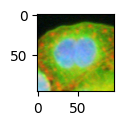

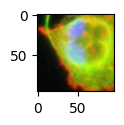

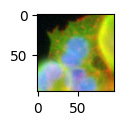

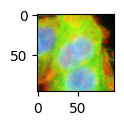

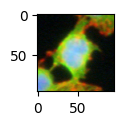

30.0


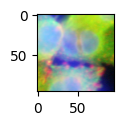

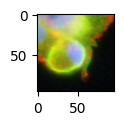

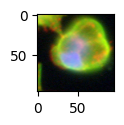

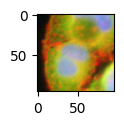

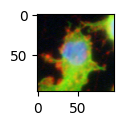

Step 0


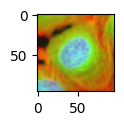

Step 1


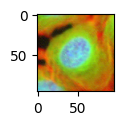

Step 2


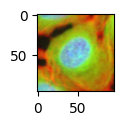

Step 3


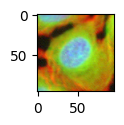

Step 4


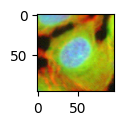

Step 5


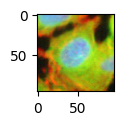

Step 6


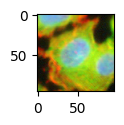

Step 7


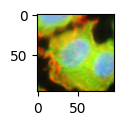

Step 8


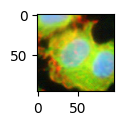

Step 9


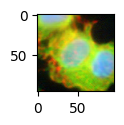

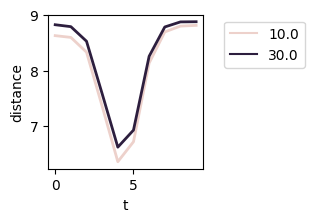

In [10]:
weeks_cyto = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="cytochalasin B"].BATCH]))

images_dosages_cyto, images_controls_cyto, style_controls_cyto = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "cytochalasin B", 
                                                                                            weeks_cyto, 
                                                                                            solver)

generated_interpolations_cyto = interpolate_and_measure_distance(solver, 
                                                                 images_controls_cyto[:64], 
                                                                 style_controls_cyto[:64],
                                                                 dataloader, 
                                                                 "cytochalasin B", 
                                                                 args)

for id in images_dosages_cyto:
    print(id)
    for i, im in enumerate(images_dosages_cyto[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 4:
            break

for id in generated_interpolations_cyto:
    print(f"Step {id}")
    for im in generated_interpolations_cyto[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_cyto = compute_distances_to_dosages(images_dosages_cyto, generated_interpolations_cyto, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_cyto, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.7, 1))
plt.show()

**Nocodazole**

100%|██████████| 194/194 [00:21<00:00,  9.02it/s]


3.0


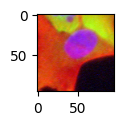

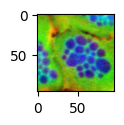

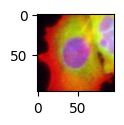

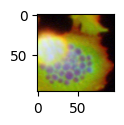

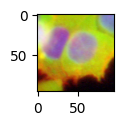

1.0


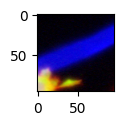

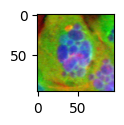

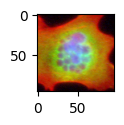

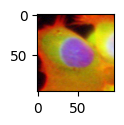

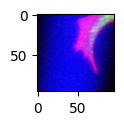

Step 0


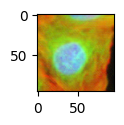

Step 1


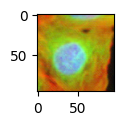

Step 2


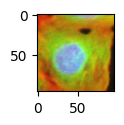

Step 3


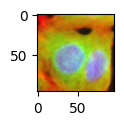

Step 4


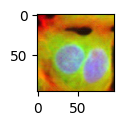

Step 5


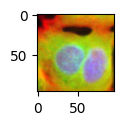

Step 6


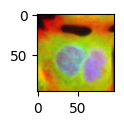

Step 7


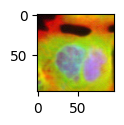

Step 8


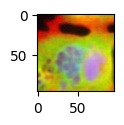

Step 9


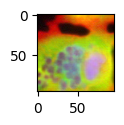

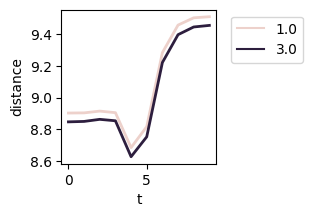

In [11]:
weeks_noco = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="nocodazole"].BATCH]))

images_dosages_noco, images_controls_noco, style_controls_noco = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "nocodazole", 
                                                                                            weeks_noco, 
                                                                                            solver)

generated_interpolations_noco = interpolate_and_measure_distance(solver, 
                                                                 images_controls_noco[:64], 
                                                                 style_controls_noco[:64],
                                                                 dataloader, 
                                                                 "nocodazole", 
                                                                 args)

for id in images_dosages_noco:
    print(id)
    for i, im in enumerate(images_dosages_noco[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 4:
            break

for id in generated_interpolations_noco:
    print(f"Step {id}")
    for im in generated_interpolations_noco[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_noco = compute_distances_to_dosages(images_dosages_noco, generated_interpolations_noco, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_noco, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

AZ258

100%|██████████| 194/194 [00:18<00:00, 10.30it/s]


Step 0


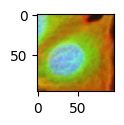

Step 1


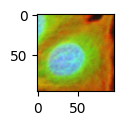

Step 2


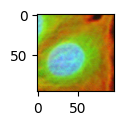

Step 3


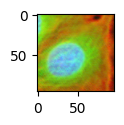

Step 4


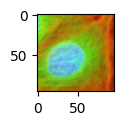

Step 5


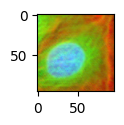

Step 6


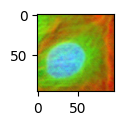

Step 7


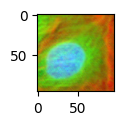

Step 8


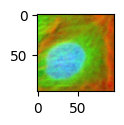

Step 9


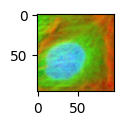

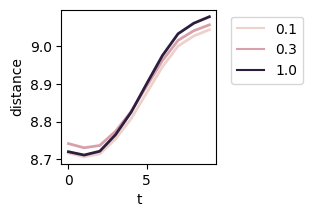

In [12]:
weeks_AZ258 = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="AZ258"].BATCH]))

images_dosages_AZ258, images_controls_AZ258, style_controls_AZ258 = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "AZ258", 
                                                                                            weeks_AZ258, 
                                                                                            solver)

generated_interpolations_AZ258 = interpolate_and_measure_distance(solver, 
                                                                  images_controls_AZ258[:64], 
                                                                  style_controls_AZ258[:64],
                                                                  dataloader, 
                                                                  "AZ258", 
                                                                  args)
for id in generated_interpolations_AZ258:
    print(f"Step {id}")
    for im in generated_interpolations_AZ258[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_AZ258 = compute_distances_to_dosages(images_dosages_AZ258, generated_interpolations_AZ258, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_AZ258, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

taxol

100%|██████████| 194/194 [00:18<00:00, 10.45it/s]


Step 0


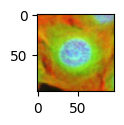

Step 1


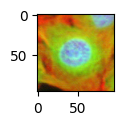

Step 2


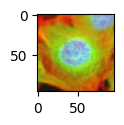

Step 3


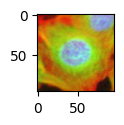

Step 4


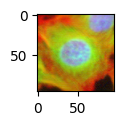

Step 5


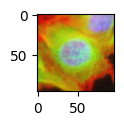

Step 6


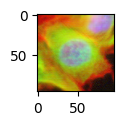

Step 7


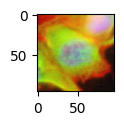

Step 8


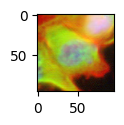

Step 9


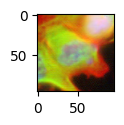

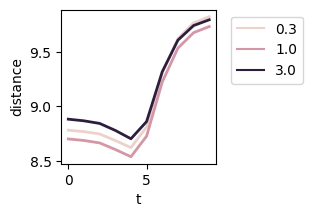

In [13]:
weeks_taxol = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="taxol"].BATCH]))

images_dosages_taxol, images_controls_taxol, style_controls_taxol = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "taxol", 
                                                                                            weeks_taxol, 
                                                                                            solver)

generated_interpolations_taxol = interpolate_and_measure_distance(solver, 
                                                                 images_controls_taxol[:64], 
                                                                 style_controls_taxol[:64],
                                                                 dataloader, 
                                                                 "taxol", 
                                                                 args)

for id in generated_interpolations_taxol:
    print(f"Step {id}")
    for im in generated_interpolations_taxol[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_taxol = compute_distances_to_dosages(images_dosages_taxol, generated_interpolations_taxol, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_taxol, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

AZ138

100%|██████████| 194/194 [00:17<00:00, 11.39it/s]


Step 0


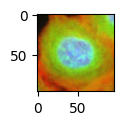

Step 1


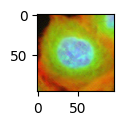

Step 2


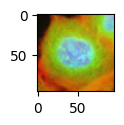

Step 3


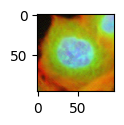

Step 4


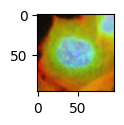

Step 5


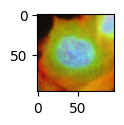

Step 6


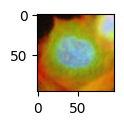

Step 7


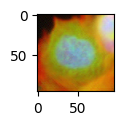

Step 8


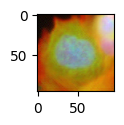

Step 9


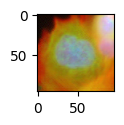

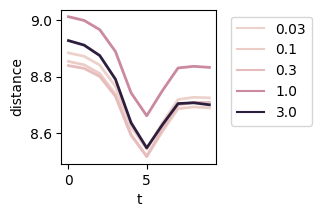

In [14]:
weeks_AZ138 = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="AZ138"].BATCH]))

images_dosages_AZ138, images_controls_AZ138, style_controls_AZ138 = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "AZ138", 
                                                                                            weeks_AZ138, 
                                                                                            solver)

generated_interpolations_AZ138 = interpolate_and_measure_distance(solver, 
                                                                 images_controls_AZ138[:64], 
                                                                 style_controls_AZ138[:64],
                                                                 dataloader, 
                                                                 "AZ138", 
                                                                 args)

for id in generated_interpolations_AZ138:
    print(f"Step {id}")
    for im in generated_interpolations_AZ138[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_AZ138 = compute_distances_to_dosages(images_dosages_AZ138, generated_interpolations_AZ138, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_AZ138, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

mevinolin/lovastatin

100%|██████████| 194/194 [00:15<00:00, 12.20it/s]


Step 0


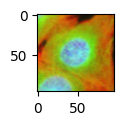

Step 1


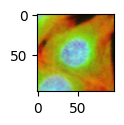

Step 2


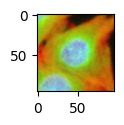

Step 3


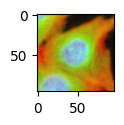

Step 4


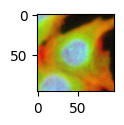

Step 5


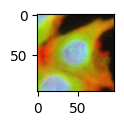

Step 6


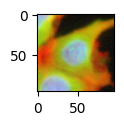

Step 7


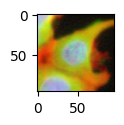

Step 8


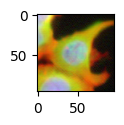

Step 9


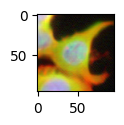

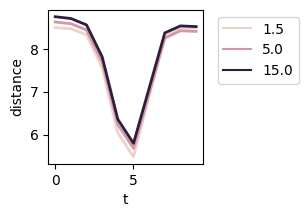

In [15]:
weeks_mevi = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="mevinolin/lovastatin"].BATCH]))

images_dosages_mevi, images_controls_mevi, style_controls_mevi = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "mevinolin/lovastatin", 
                                                                                            weeks_mevi, 
                                                                                            solver)

generated_interpolations_mevi = interpolate_and_measure_distance(solver, 
                                                                 images_controls_mevi[:64], 
                                                                 style_controls_mevi[:64],
                                                                 dataloader, 
                                                                 "mevinolin/lovastatin", 
                                                                 args)

for id in generated_interpolations_mevi:
    print(f"Step {id}")
    for im in generated_interpolations_mevi[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_mevi = compute_distances_to_dosages(images_dosages_mevi, generated_interpolations_mevi, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_mevi, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

mitomycin C 

100%|██████████| 194/194 [00:14<00:00, 13.04it/s]


Step 0


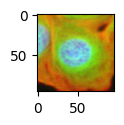

Step 1


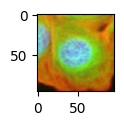

Step 2


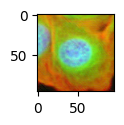

Step 3


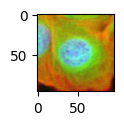

Step 4


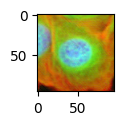

Step 5


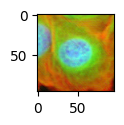

Step 6


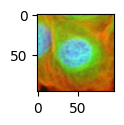

Step 7


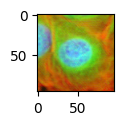

Step 8


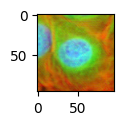

Step 9


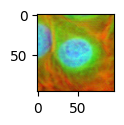

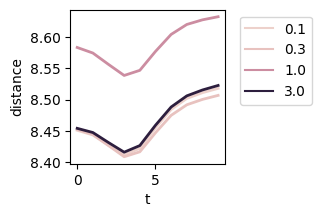

In [16]:
weeks_mitomy = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="mitomycin C"].BATCH]))

images_dosages_mitomy, images_controls_mitomy, style_controls_mitomy = measure_dose_correlation_curves(data_index, 
                                                                                                        dataloader, 
                                                                                                        "mitomycin C", 
                                                                                                        weeks_mitomy, 
                                                                                                        solver)

generated_interpolations_mitomy = interpolate_and_measure_distance(solver, 
                                                                 images_controls_mitomy[:64], 
                                                                 style_controls_mitomy[:64],
                                                                 dataloader, 
                                                                 "mitomycin C", 
                                                                 args)

for id in generated_interpolations_mitomy:
    print(f"Step {id}")
    for im in generated_interpolations_mitomy[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_mitomy = compute_distances_to_dosages(images_dosages_mitomy, generated_interpolations_mitomy, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_mitomy, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

mitoxantrone

100%|██████████| 194/194 [00:14<00:00, 12.94it/s]


Step 0


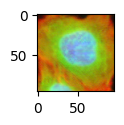

Step 1


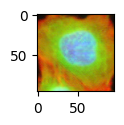

Step 2


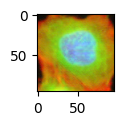

Step 3


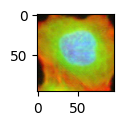

Step 4


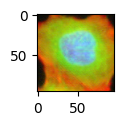

Step 5


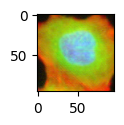

Step 6


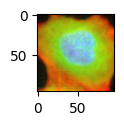

Step 7


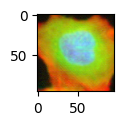

Step 8


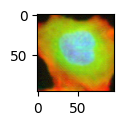

Step 9


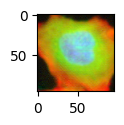

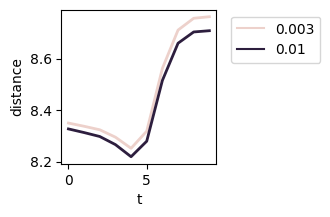

In [17]:
weeks_mitox = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="mitoxantrone"].BATCH]))

images_dosages_mitox, images_controls_mitox, style_controls_mitox = measure_dose_correlation_curves(data_index, 
                                                                                                        dataloader, 
                                                                                                        "mitoxantrone", 
                                                                                                        weeks_mitox, 
                                                                                                        solver)

generated_interpolations_mitox = interpolate_and_measure_distance(solver, 
                                                                 images_controls_mitox[:64], 
                                                                 style_controls_mitox[:64],
                                                                 dataloader, 
                                                                 "mitoxantrone", 
                                                                 args)

for id in generated_interpolations_mitox:
    print(f"Step {id}")
    for im in generated_interpolations_mitox[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_mitox = compute_distances_to_dosages(images_dosages_mitox, generated_interpolations_mitox, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_mitox, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

protease inhibitor I

100%|██████████| 194/194 [00:13<00:00, 14.11it/s]


Step 0


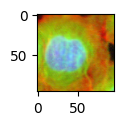

Step 1


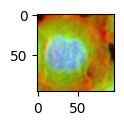

Step 2


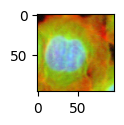

Step 3


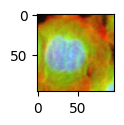

Step 4


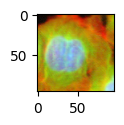

Step 5


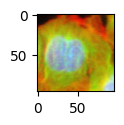

Step 6


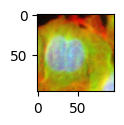

Step 7


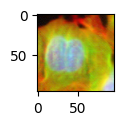

Step 8


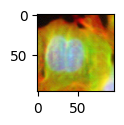

Step 9


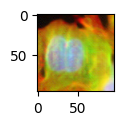

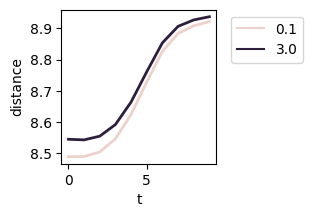

In [18]:
weeks_prote = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="proteasome inhibitor I"].BATCH]))

images_dosages_prote, images_controls_prote, style_controls_prote = measure_dose_correlation_curves(data_index, 
                                                                                                        dataloader, 
                                                                                                        "proteasome inhibitor I", 
                                                                                                        weeks_prote, 
                                                                                                        solver)

generated_interpolations_prote = interpolate_and_measure_distance(solver, 
                                                                 images_controls_prote[:64], 
                                                                 style_controls_prote[:64],
                                                                 dataloader, 
                                                                 "proteasome inhibitor I", 
                                                                 args)

for id in generated_interpolations_prote:
    print(f"Step {id}")
    for im in generated_interpolations_prote[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_prote = compute_distances_to_dosages(images_dosages_prote, generated_interpolations_prote, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_prote, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

vincristine

100%|██████████| 194/194 [00:13<00:00, 13.93it/s]


Step 0


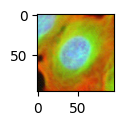

Step 1


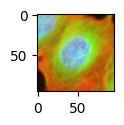

Step 2


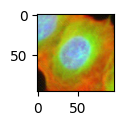

Step 3


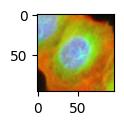

Step 4


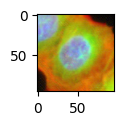

Step 5


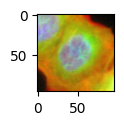

Step 6


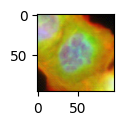

Step 7


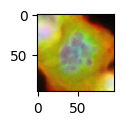

Step 8


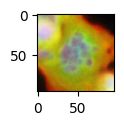

Step 9


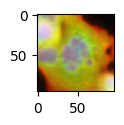

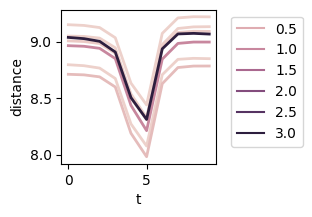

In [19]:
weeks_vincristine = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="vincristine"].BATCH]))

images_dosages_vincristine, images_controls_vincristine, style_controls_vincristine = measure_dose_correlation_curves(data_index, 
                                                                                                        dataloader, 
                                                                                                        "vincristine", 
                                                                                                        weeks_vincristine, 
                                                                                                        solver)

generated_interpolations_vincristine = interpolate_and_measure_distance(solver, 
                                                                 images_controls_vincristine[:64], 
                                                                 style_controls_vincristine[:64],
                                                                 dataloader, 
                                                                 "vincristine", 
                                                                 args)

for id in generated_interpolations_vincristine:
    print(f"Step {id}")
    for im in generated_interpolations_vincristine[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_vincristine = compute_distances_to_dosages(images_dosages_vincristine, generated_interpolations_vincristine, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_vincristine, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

demecolcine

100%|██████████| 194/194 [00:13<00:00, 14.81it/s]


Step 0


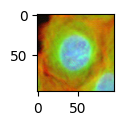

Step 1


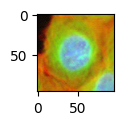

Step 2


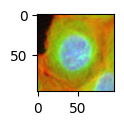

Step 3


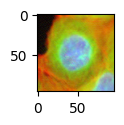

Step 4


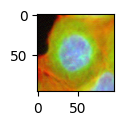

Step 5


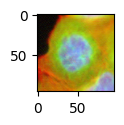

Step 6


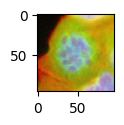

Step 7


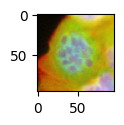

Step 8


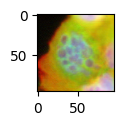

Step 9


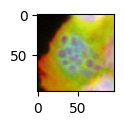

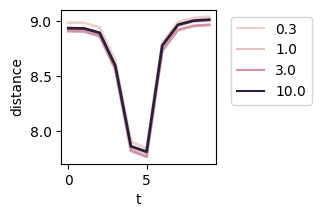

In [20]:
weeks_demecolcine = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="demecolcine"].BATCH]))

images_dosages_demecolcine, images_controls_demecolcine, style_controls_demecolcine = measure_dose_correlation_curves(data_index, 
                                                                                                        dataloader, 
                                                                                                        "demecolcine", 
                                                                                                        weeks_demecolcine,
                                                                                                        solver)

generated_interpolations_demecolcine = interpolate_and_measure_distance(solver, 
                                                                 images_controls_demecolcine[:64], 
                                                                 style_controls_demecolcine[:64],
                                                                 dataloader, 
                                                                 "demecolcine", 
                                                                 args)

for id in generated_interpolations_demecolcine:
    print(f"Step {id}")
    for im in generated_interpolations_demecolcine[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_demecolcine = compute_distances_to_dosages(images_dosages_demecolcine, generated_interpolations_demecolcine, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_demecolcine, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# Do analyis for Cytochalasin B and nocodazole if they are different in different contexts

In [21]:
from cellpose import models, utils
from skimage.feature import graycomatrix, graycoprops

from skimage.measure import regionprops, regionprops_table

CHANNELS = {0: "actin", 
            1: "tubulin", 
            2: "nucleus"}

def compute_texture_features(image):
    """
    Compute texture features using GLCM (Gray-Level Co-occurrence Matrix).

    Parameters:
    - image: grayscale image.

    Returns:
    - texture_features: dictionary containing texture features.
    """
    # Compute GLCM
    image_uint = (image*255.).astype(np.uint8)
    # Compute texture properties from GLCM
    texture_props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    texture_features = {}
    for ch in range(3):
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = graycomatrix(image_uint[:, :, ch], distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

        for prop in texture_props:
            texture_features[prop+"_"+CHANNELS[ch]] = graycoprops(glcm, prop).ravel()[0]
    
    return texture_features

def cellpose_segmentation(images):
    """
    Perform Cellpose segmentation on a batch of images and measure all available region properties.

    Parameters:
    - images: numpy array of shape (N, H, W) containing N images.

    Returns:
    - region_props: a table of region properties for each segmented region.
    """
    # Define Cellpose model for 2D images
    model = models.Cellpose(gpu=True, model_type='cyto')  # gpu=True if you have GPU support

    # Results for Regionprops and texture (per channel)
    region_props_res = {}
    texture_features_res = {}
        
    # Process each image in the batch
    for i in tqdm(range(len(images))):
        image = images[i]
        for ch in range(3):
            if CHANNELS[ch] == "nucleus":
                # Segment the cells
                masks, flows, styles, diams = model.eval(image[:,:,ch], diameter=None, channels=[0,0])
            else:
                masks = np.ones_like(image[:,:,0])
            
            # Get region properties
            props = regionprops_table(masks.astype(int), image[:,:,ch], properties=('area', 
                                                                                    'eccentricity', 
                                                                                    'intensity_max', 
                                                                                    'intensity_mean', 
                                                                                    'intensity_min',
                                                                                    'label',
                                                                                    'perimeter', 
                                                                                    'solidity'))
            for key in props:
                props_mean = np.mean(props[key])
                key = key+"_"+CHANNELS[ch]
                if key not in region_props_res:
                    region_props_res[key] = np.array([props_mean])
                else:
                    region_props_res[key] = np.concatenate([region_props_res[key], np.array([props_mean])])

        # Compute texture features
        texture_features = compute_texture_features(image)
        for key in texture_features:
            if key not in texture_features_res:
                texture_features_res[key] = np.array([texture_features[key]])
            else:
                texture_features_res[key] = np.concatenate([texture_features_res[key], np.array([texture_features[key]])])
                
    return region_props_res, texture_features_res

## Compute the features for all the images

### Nocodazole

Real dosages

In [22]:
dose_shape_features_noco = {}
dose_texture_features_noco = {}

interp_shape_features_noco = {}
interp_texture_features_noco = {}

for d in images_dosages_noco:
    features_d = cellpose_segmentation(t2np(images_dosages_noco[d], batch_dim=True))
    dose_shape_features_noco[d] = features_d[0]
    dose_texture_features_noco[d] = features_d[1]

for id in generated_interpolations_noco:
    features_id = cellpose_segmentation(t2np(generated_interpolations_noco[id], batch_dim=True))
    interp_shape_features_noco[id] = features_id[0]
    interp_texture_features_noco[id] = features_id[1]

  6%|▌         | 4/68 [00:01<00:30,  2.10it/s]/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 64/64 [00:33<00:00,  1.94it/s]


**Check the features of real dosage images**

In [23]:
print(pd.DataFrame(dose_shape_features_noco[1.0]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_noco[3.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_noco[1.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_noco[3.0]).mean(0))
print()

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.498557
intensity_min_actin          0.000852
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.395971
intensity_min_tubulin        0.000190
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               892.790139
eccentricity_nucleus         0.672216
intensity_max_nucleus        0.882696
intensity_mean_nucleus       0.606663
intensity_min_nucleus        0.153225
label_nucleus                2.424242
perimeter_nucleus          109.185964
solidity_nucleus             0.951160
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [24]:
print(pd.DataFrame(interp_shape_features_noco[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_noco[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_noco[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_noco[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.971725
intensity_mean_actin         0.610806
intensity_min_actin          0.058290
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.994923
intensity_mean_tubulin       0.567068
intensity_min_tubulin        0.025651
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1064.294271
eccentricity_nucleus         0.652137
intensity_max_nucleus        0.947476
intensity_mean_nucleus       0.677666
intensity_min_nucleus        0.170392
label_nucleus                1.460938
perimeter_nucleus          117.586144
solidity_nucleus             0.972941
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

### Cytochalasin B

In [25]:
dose_shape_features_cyto = {}
dose_texture_features_cyto = {}

interp_shape_features_cyto = {}
interp_texture_features_cyto = {}

for d in images_dosages_cyto:
    features_d = cellpose_segmentation(t2np(images_dosages_cyto[d], batch_dim=True))
    dose_shape_features_cyto[d] = features_d[0]
    dose_texture_features_cyto[d] = features_d[1]

for id in generated_interpolations_cyto:
    features_id = cellpose_segmentation(t2np(generated_interpolations_cyto[id], batch_dim=True))
    interp_shape_features_cyto[id] = features_id[0]
    interp_texture_features_cyto[id] = features_id[1]

100%|██████████| 64/64 [00:31<00:00,  2.05it/s]


**Check the features of real dosage images**

In [26]:
print(pd.DataFrame(dose_shape_features_cyto[10.0]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_cyto[30.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_cyto[10.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_cyto[30.0]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.424645
intensity_min_actin          0.000141
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.499733
intensity_min_tubulin        0.000712
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               706.469276
eccentricity_nucleus         0.662942
intensity_max_nucleus        0.927766
intensity_mean_nucleus       0.664126
intensity_min_nucleus        0.193517
label_nucleus                2.328767
perimeter_nucleus           99.644273
solidity_nucleus             0.963845
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [27]:
print(pd.DataFrame(interp_shape_features_cyto[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_cyto[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_cyto[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_cyto[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.956934
intensity_mean_actin         0.604404
intensity_min_actin          0.058366
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.996243
intensity_mean_tubulin       0.568945
intensity_min_tubulin        0.023248
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1152.567708
eccentricity_nucleus         0.640973
intensity_max_nucleus        0.952021
intensity_mean_nucleus       0.687714
intensity_min_nucleus        0.171510
label_nucleus                1.398438
perimeter_nucleus          122.788551
solidity_nucleus             0.974276
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

### Taxol

In [28]:
dose_shape_features_taxol = {}
dose_texture_features_taxol = {}

interp_shape_features_taxol = {}
interp_texture_features_taxol = {}

for d in images_dosages_taxol:
    features_d = cellpose_segmentation(t2np(images_dosages_taxol[d], batch_dim=True))
    dose_shape_features_taxol[d] = features_d[0]
    dose_texture_features_taxol[d] = features_d[1]

for id in generated_interpolations_taxol:
    features_id = cellpose_segmentation(t2np(generated_interpolations_taxol[id], batch_dim=True))
    interp_shape_features_taxol[id] = features_id[0]
    interp_texture_features_taxol[id] = features_id[1]

100%|██████████| 64/64 [00:32<00:00,  1.99it/s]


In [29]:
print(pd.DataFrame(dose_shape_features_taxol[0.3]).mean(0))
print()
pd.DataFrame(dose_shape_features_taxol[3]).mean(0)
print()
print(pd.DataFrame(dose_texture_features_taxol[0.3]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_taxol[3]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.549675
intensity_min_actin          0.000545
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.452522
intensity_min_tubulin        0.001037
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               972.721949
eccentricity_nucleus         0.700888
intensity_max_nucleus        0.856546
intensity_mean_nucleus       0.574684
intensity_min_nucleus        0.146572
label_nucleus                2.203125
perimeter_nucleus          115.491251
solidity_nucleus             0.954424
dtype: float64


contrast_actin            54.490550
dissimilarity_actin        4.771025

In [30]:
print(pd.DataFrame(interp_shape_features_taxol[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_taxol[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_taxol[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_taxol[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.956370
intensity_mean_actin         0.608826
intensity_min_actin          0.068103
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.997354
intensity_mean_tubulin       0.565578
intensity_min_tubulin        0.023785
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1122.372396
eccentricity_nucleus         0.649547
intensity_max_nucleus        0.954586
intensity_mean_nucleus       0.687195
intensity_min_nucleus        0.174583
label_nucleus                1.406250
perimeter_nucleus          120.754033
solidity_nucleus             0.973553
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

### AZ138

In [31]:
dose_shape_features_AZ138 = {}
dose_texture_features_AZ138 = {}

interp_shape_features_AZ138 = {}
interp_texture_features_AZ138 = {}

for d in images_dosages_AZ138:
    features_d = cellpose_segmentation(t2np(images_dosages_AZ138[d], batch_dim=True))
    dose_shape_features_AZ138[d] = features_d[0]
    dose_texture_features_AZ138[d] = features_d[1]

for id in generated_interpolations_AZ138:
    features_id = cellpose_segmentation(t2np(generated_interpolations_AZ138[id], batch_dim=True))
    interp_shape_features_AZ138[id] = features_id[0]
    interp_texture_features_AZ138[id] = features_id[1]

 62%|██████▏   | 41/66 [00:21<00:13,  1.82it/s]/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 64/64 [00:31<00:00,  2.03it/s]


In [32]:
print(pd.DataFrame(dose_shape_features_AZ138[0.03]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_AZ138[3]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_AZ138[0.03]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_AZ138[3]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.514744
intensity_min_actin          0.000660
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.437686
intensity_min_tubulin        0.000341
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               911.578179
eccentricity_nucleus         0.671283
intensity_max_nucleus        0.867469
intensity_mean_nucleus       0.598201
intensity_min_nucleus        0.175294
label_nucleus                2.329670
perimeter_nucleus          112.702633
solidity_nucleus             0.962222
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [33]:
print(pd.DataFrame(interp_shape_features_AZ138[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_AZ138[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_AZ138[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_AZ138[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.965363
intensity_mean_actin         0.612775
intensity_min_actin          0.071079
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.995083
intensity_mean_tubulin       0.565744
intensity_min_tubulin        0.028047
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1032.769531
eccentricity_nucleus         0.673534
intensity_max_nucleus        0.942568
intensity_mean_nucleus       0.671572
intensity_min_nucleus        0.167166
label_nucleus                1.539062
perimeter_nucleus          114.871491
solidity_nucleus             0.971145
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## AZ258

In [34]:
dose_shape_features_AZ258 = {}
dose_texture_features_AZ258 = {}

interp_shape_features_AZ258 = {}
interp_texture_features_AZ258 = {}

for d in images_dosages_AZ258:
    features_d = cellpose_segmentation(t2np(images_dosages_AZ258[d], batch_dim=True))
    dose_shape_features_AZ258[d] = features_d[0]
    dose_texture_features_AZ258[d] = features_d[1]

for id in generated_interpolations_AZ258:
    features_id = cellpose_segmentation(t2np(generated_interpolations_AZ258[id], batch_dim=True))
    interp_shape_features_AZ258[id] = features_id[0]
    interp_texture_features_AZ258[id] = features_id[1]

100%|██████████| 64/64 [00:32<00:00,  1.97it/s]


In [35]:
print(pd.DataFrame(dose_shape_features_AZ258[0.1]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_AZ258[1]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_AZ258[0.1]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_AZ258[1]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.470408
intensity_min_actin          0.001358
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.529996
intensity_min_tubulin        0.000933
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1180.712710
eccentricity_nucleus         0.698380
intensity_max_nucleus        0.933595
intensity_mean_nucleus       0.686504
intensity_min_nucleus        0.181898
label_nucleus                1.872180
perimeter_nucleus          126.823483
solidity_nucleus             0.960133
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [36]:
print(pd.DataFrame(interp_shape_features_AZ258[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_AZ258[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_AZ258[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_AZ258[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.959033
intensity_mean_actin         0.606705
intensity_min_actin          0.059005
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.995950
intensity_mean_tubulin       0.566755
intensity_min_tubulin        0.023850
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1184.255208
eccentricity_nucleus         0.632624
intensity_max_nucleus        0.956807
intensity_mean_nucleus       0.683467
intensity_min_nucleus        0.165886
label_nucleus                1.367188
perimeter_nucleus          124.886211
solidity_nucleus             0.972818
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## mevinolin

In [37]:
dose_shape_features_mevin = {}
dose_texture_features_mevin = {}

interp_shape_features_mevin = {}
interp_texture_features_mevin = {}

for d in images_dosages_mevi:
    features_d = cellpose_segmentation(t2np(images_dosages_mevi[d], batch_dim=True))
    dose_shape_features_mevin[d] = features_d[0]
    dose_texture_features_mevin[d] = features_d[1]

for id in generated_interpolations_mevi:
    features_id = cellpose_segmentation(t2np(generated_interpolations_mevi[id], batch_dim=True))
    interp_shape_features_mevin[id] = features_id[0]
    interp_texture_features_mevin[id] = features_id[1]

100%|██████████| 64/64 [00:29<00:00,  2.15it/s]


In [38]:
print(pd.DataFrame(dose_shape_features_mevin[1.5]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_mevin[15]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mevin[1.5]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mevin[15]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.476726
intensity_min_actin          0.000612
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.422793
intensity_min_tubulin        0.000283
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               677.244393
eccentricity_nucleus         0.700242
intensity_max_nucleus        0.901771
intensity_mean_nucleus       0.652728
intensity_min_nucleus        0.193449
label_nucleus                2.402439
perimeter_nucleus           96.437374
solidity_nucleus             0.966660
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [39]:
print(pd.DataFrame(interp_shape_features_mevin[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_mevin[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mevin[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mevin[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.953687
intensity_mean_actin         0.601094
intensity_min_actin          0.050496
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.998483
intensity_mean_tubulin       0.569840
intensity_min_tubulin        0.019871
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1099.580729
eccentricity_nucleus         0.662623
intensity_max_nucleus        0.951828
intensity_mean_nucleus       0.681511
intensity_min_nucleus        0.169458
label_nucleus                1.445312
perimeter_nucleus          121.749742
solidity_nucleus             0.972538
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## mitomycin C

In [40]:
dose_shape_features_mitomy = {}
dose_texture_features_mitomy = {}

interp_shape_features_mitomy = {}
interp_texture_features_mitomy = {}

for d in images_dosages_mitomy:
    features_d = cellpose_segmentation(t2np(images_dosages_mitomy[d], batch_dim=True))
    dose_shape_features_mitomy[d] = features_d[0]
    dose_texture_features_mitomy[d] = features_d[1]

for id in generated_interpolations_mitomy:
    features_id = cellpose_segmentation(t2np(generated_interpolations_mitomy[id], batch_dim=True))
    interp_shape_features_mitomy[id] = features_id[0]
    interp_texture_features_mitomy[id] = features_id[1]

100%|██████████| 64/64 [00:28<00:00,  2.23it/s]


In [41]:
print(pd.DataFrame(dose_shape_features_mitomy[0.1]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_mitomy[1]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mitomy[0.1]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mitomy[1]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.536494
intensity_min_actin          0.001550
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.522289
intensity_min_tubulin        0.001061
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1048.852156
eccentricity_nucleus         0.651463
intensity_max_nucleus        0.937532
intensity_mean_nucleus       0.679351
intensity_min_nucleus        0.180109
label_nucleus                1.811111
perimeter_nucleus          118.695503
solidity_nucleus             0.972569
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [42]:
print(pd.DataFrame(interp_shape_features_mitomy[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_mitomy[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mitomy[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mitomy[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.956909
intensity_mean_actin         0.606296
intensity_min_actin          0.064525
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.998013
intensity_mean_tubulin       0.566615
intensity_min_tubulin        0.023921
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1148.302083
eccentricity_nucleus         0.626757
intensity_max_nucleus        0.953858
intensity_mean_nucleus       0.686015
intensity_min_nucleus        0.164946
label_nucleus                1.421875
perimeter_nucleus          123.290832
solidity_nucleus             0.974062
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## mitoxantrone

In [43]:
dose_shape_features_mitox = {}
dose_texture_features_mitox = {}

interp_shape_features_mitox = {}
interp_texture_features_mitox = {}

for d in images_dosages_mitox:
    features_d = cellpose_segmentation(t2np(images_dosages_mitox[d], batch_dim=True))
    dose_shape_features_mitox[d] = features_d[0]
    dose_texture_features_mitox[d] = features_d[1]

for id in generated_interpolations_mitox:
    features_id = cellpose_segmentation(t2np(generated_interpolations_mitox[id], batch_dim=True))
    interp_shape_features_mitox[id] = features_id[0]
    interp_texture_features_mitox[id] = features_id[1]

100%|██████████| 64/64 [00:30<00:00,  2.10it/s]


In [44]:
print(pd.DataFrame(dose_shape_features_mitox[0.003]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_mitox[0.01]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mitox[0.003]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mitox[0.01]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.522239
intensity_min_actin          0.000853
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.465294
intensity_min_tubulin        0.000422
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               827.723504
eccentricity_nucleus         0.705129
intensity_max_nucleus        0.921821
intensity_mean_nucleus       0.658487
intensity_min_nucleus        0.169482
label_nucleus                1.756410
perimeter_nucleus          106.388806
solidity_nucleus             0.969544
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [45]:
print(pd.DataFrame(interp_shape_features_mitox[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_mitox[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mitox[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mitox[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.957199
intensity_mean_actin         0.606970
intensity_min_actin          0.060075
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.997500
intensity_mean_tubulin       0.567852
intensity_min_tubulin        0.022818
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1140.442708
eccentricity_nucleus         0.666485
intensity_max_nucleus        0.957639
intensity_mean_nucleus       0.687197
intensity_min_nucleus        0.163610
label_nucleus                1.406250
perimeter_nucleus          123.188807
solidity_nucleus             0.974569
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## protease inhibitor I

In [46]:
dose_shape_features_prote = {}
dose_texture_features_prote = {}

interp_shape_features_prote = {}
interp_texture_features_prote = {}

for d in images_dosages_prote:
    features_d = cellpose_segmentation(t2np(images_dosages_prote[d], batch_dim=True))
    dose_shape_features_prote[d] = features_d[0]
    dose_texture_features_prote[d] = features_d[1]

for id in generated_interpolations_prote:
    features_id = cellpose_segmentation(t2np(generated_interpolations_prote[id], batch_dim=True))
    interp_shape_features_prote[id] = features_id[0]
    interp_texture_features_prote[id] = features_id[1]

100%|██████████| 64/64 [00:33<00:00,  1.92it/s]


In [47]:
print(pd.DataFrame(dose_shape_features_prote[0.1]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_prote[3.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_prote[0.1]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_prote[3.0]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.550331
intensity_min_actin          0.000727
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.491886
intensity_min_tubulin        0.000293
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1000.881660
eccentricity_nucleus         0.699242
intensity_max_nucleus        0.933287
intensity_mean_nucleus       0.670214
intensity_min_nucleus        0.192705
label_nucleus                1.873874
perimeter_nucleus          116.735683
solidity_nucleus             0.970673
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [48]:
print(pd.DataFrame(interp_shape_features_prote[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_prote[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_prote[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_prote[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.973685
intensity_mean_actin         0.614533
intensity_min_actin          0.081650
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.995396
intensity_mean_tubulin       0.568210
intensity_min_tubulin        0.031008
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1259.229167
eccentricity_nucleus         0.630176
intensity_max_nucleus        0.947998
intensity_mean_nucleus       0.680647
intensity_min_nucleus        0.158500
label_nucleus                1.367188
perimeter_nucleus          127.864181
solidity_nucleus             0.971928
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## vincristine

In [49]:
dose_shape_features_vincristine = {}
dose_texture_features_vincristine = {}

interp_shape_features_vincristine = {}
interp_texture_features_vincristine = {}

for d in images_dosages_vincristine:
    features_d = cellpose_segmentation(t2np(images_dosages_vincristine[d], batch_dim=True))
    dose_shape_features_vincristine[d] = features_d[0]
    dose_texture_features_vincristine[d] = features_d[1]

for id in generated_interpolations_vincristine:
    features_id = cellpose_segmentation(t2np(generated_interpolations_vincristine[id], batch_dim=True))
    interp_shape_features_vincristine[id] = features_id[0]
    interp_texture_features_vincristine[id] = features_id[1]

 82%|████████▏ | 28/34 [00:15<00:02,  2.03it/s]/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 64/64 [00:31<00:00,  2.00it/s]


In [50]:
print(pd.DataFrame(dose_shape_features_vincristine[0.003]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_vincristine[1.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_vincristine[0.003]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_vincristine[1.0]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.498157
intensity_min_actin          0.000871
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.420526
intensity_min_tubulin        0.000171
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               570.062320
eccentricity_nucleus         0.662082
intensity_max_nucleus        0.823300
intensity_mean_nucleus       0.576487
intensity_min_nucleus        0.200635
label_nucleus                3.481250
perimeter_nucleus           86.651888
solidity_nucleus             0.945807
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [51]:
print(pd.DataFrame(interp_shape_features_vincristine[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_vincristine[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_vincristine[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_vincristine[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.957901
intensity_mean_actin         0.609956
intensity_min_actin          0.065909
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.996549
intensity_mean_tubulin       0.566947
intensity_min_tubulin        0.024145
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1172.938802
eccentricity_nucleus         0.633376
intensity_max_nucleus        0.958544
intensity_mean_nucleus       0.685212
intensity_min_nucleus        0.164075
label_nucleus                1.398438
perimeter_nucleus          123.779945
solidity_nucleus             0.972004
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## demecolcine

In [52]:
dose_shape_features_demecolcine = {}
dose_texture_features_demecolcine = {}

interp_shape_features_demecolcine = {}
interp_texture_features_demecolcine = {}

for d in images_dosages_demecolcine:
    features_d = cellpose_segmentation(t2np(images_dosages_demecolcine[d], batch_dim=True))
    dose_shape_features_demecolcine[d] = features_d[0]
    dose_texture_features_demecolcine[d] = features_d[1]

for id in generated_interpolations_demecolcine:
    features_id = cellpose_segmentation(t2np(generated_interpolations_demecolcine[id], batch_dim=True))
    interp_shape_features_demecolcine[id] = features_id[0]
    interp_texture_features_demecolcine[id] = features_id[1]

 23%|██▎       | 14/60 [00:06<00:21,  2.11it/s]/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 64/64 [00:46<00:00,  1.38it/s]


In [53]:
print(pd.DataFrame(dose_shape_features_demecolcine[0.3]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_demecolcine[10.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_demecolcine[0.3]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_demecolcine[10.0]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.536000
intensity_min_actin          0.000854
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.509590
intensity_min_tubulin        0.000610
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               771.663117
eccentricity_nucleus         0.686229
intensity_max_nucleus        0.816868
intensity_mean_nucleus       0.586850
intensity_min_nucleus        0.203697
label_nucleus                3.291667
perimeter_nucleus          101.661092
solidity_nucleus             0.947597
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [54]:
print(pd.DataFrame(interp_shape_features_demecolcine[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_demecolcine[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_demecolcine[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_demecolcine[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.956061
intensity_mean_actin         0.608754
intensity_min_actin          0.051810
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.997490
intensity_mean_tubulin       0.567698
intensity_min_tubulin        0.019263
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1070.398438
eccentricity_nucleus         0.661786
intensity_max_nucleus        0.951890
intensity_mean_nucleus       0.684125
intensity_min_nucleus        0.174090
label_nucleus                1.453125
perimeter_nucleus          118.858223
solidity_nucleus             0.972291
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## Make plots

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_lineplot(dose_shape_features, interp_features, feature_to_plot, title):
    to_plot = {"t": [], 
               "value": []}
    
    for t in interp_features:
        fea = list(interp_features[t][feature_to_plot])
        to_plot["value"] += list(fea)
        to_plot["t"] += [t for _ in range(len(fea))]

    # Extract dose values and their mean feature values
    dose_marks = [(d, np.nanmean(dose_shape_features[d][feature_to_plot])) for d in dose_shape_features]
    print(dose_marks)
    
    # Sort the dose_marks list based on the dose
    dose_marks.sort(key=lambda x: x[0])
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame(to_plot)

    # Create line plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(3, 3))
    sns.lineplot(data=df, x="t", y="value", color='blue', linewidth=2, marker='o', markersize=8, markerfacecolor='blue', markeredgewidth=2, markeredgecolor='black')
    
    # Create a continuous color palette for dose values
    dose_palette = sns.color_palette("colorblind", n_colors=len(dose_marks))
    dose_color_map = {dose: dose_palette[i] for i, (dose, _) in enumerate(dose_marks)}
    
    for dose, mean_value in dose_marks:
        plt.axhline(y=mean_value, color=dose_color_map[dose], linestyle='--', linewidth=2, label=dose)
    
    plt.xlabel("t", fontsize=14)
    plt.ylabel("value", fontsize=14)
    plt.title(title, fontsize=16)

    # Customize legend
    plt.legend(title='Dose', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    
    # Customize ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Grid style
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()

# def make_lineplot(dose_shape_features, interp_features, feature_to_plot, title, y_label):
#     to_plot = {"t": [], 
#                "value": []}
    
#     for t in interp_features:
#         fea = list(interp_features[t][feature_to_plot])
#         to_plot["value"] += list(fea)
#         to_plot["t"] += [t for _ in range(len(fea))]

#     # Calculate the mean value of the feature across all doses
#     all_doses_values = [np.nanmean(dose_shape_features[d][feature_to_plot]) for d in dose_shape_features]
#     common_y_intercept = np.nanmean(all_doses_values)
    
#     # Convert dictionary to DataFrame
#     df = pd.DataFrame(to_plot)

#     # Create line plot
#     sns.set(style="whitegrid")
#     plt.figure(figsize=(3, 3))
#     sns.lineplot(data=df, x="t", y="value", color='blue', linewidth=2, marker='o', markersize=8, markerfacecolor='blue', markeredgewidth=2, markeredgecolor='black')
    
#     # Plot the common y-intercept
#     plt.axhline(y=common_y_intercept, color='red', linestyle='--', linewidth=2)
    
#     plt.xlabel("t", fontsize=14)
#     plt.ylabel(y_label, fontsize=14)
#     plt.title(title, fontsize=16)
    
#     # Customize ticks
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
    
#     # Grid style
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.savefig(f"/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/{title}.svg",
#            dpi=300, bbox_inches='tight', format='svg')
    
#     plt.show()

## Check plots

AZ138 

In [56]:
# make_lineplot(dose_shape_features_AZ138, interp_shape_features_AZ138, "area_nucleus","AZ138 - Area nucleus")

In [57]:
# make_lineplot(dose_shape_features_AZ138, interp_shape_features_AZ138, "perimeter_nucleus","AZ138 - Perimeter nucleus")

AZ258

[(0.1, 0.4704075222624872), (0.3, 0.46243181301437264), (1.0, 0.4782274089180506)]


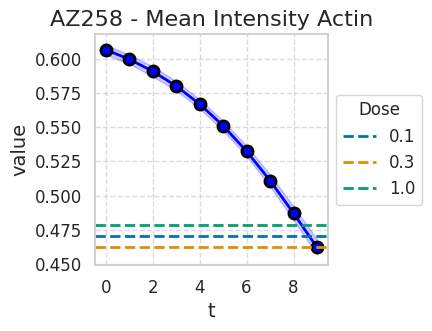

In [58]:
make_lineplot(dose_shape_features_AZ258, interp_shape_features_AZ258, "intensity_mean_actin","AZ258 - Mean Intensity Actin")

[(0.1, 126.8234831448469), (0.3, 128.84032852419142), (1.0, 126.41456371606087)]


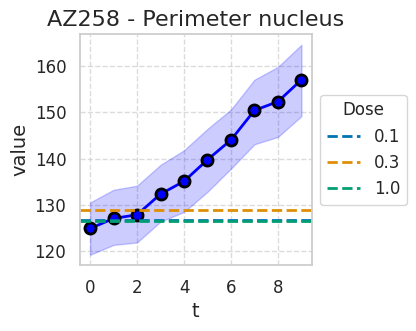

In [59]:
make_lineplot(dose_shape_features_AZ258, interp_shape_features_AZ258, "perimeter_nucleus","AZ258 - Perimeter nucleus")

Mitomycin C 

[(0.1, 118.6955025447838), (1.0, 117.07896750371208), (0.3, 116.51827205519686), (3.0, 120.05349822689055)]


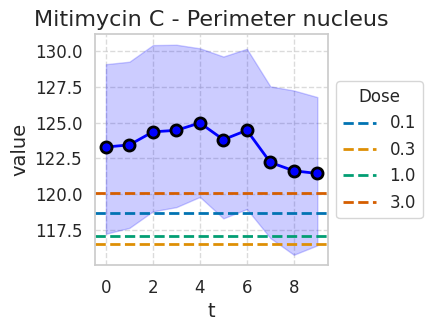

In [60]:
make_lineplot(dose_shape_features_mitomy, interp_shape_features_mitomy, "perimeter_nucleus","Mitimycin C - Perimeter nucleus")

Nocodazole

[(3.0, 106.32928746766602), (1.0, 109.18596358243516)]


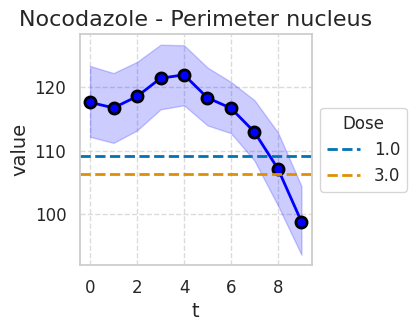

In [61]:
make_lineplot(dose_shape_features_noco, interp_shape_features_noco, "perimeter_nucleus","Nocodazole - Perimeter nucleus")

[(3.0, 876.1977517928337), (1.0, 892.7901394901394)]


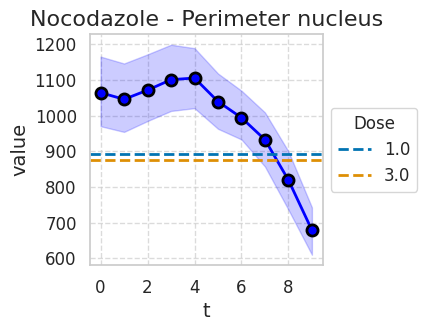

In [62]:
make_lineplot(dose_shape_features_noco, interp_shape_features_noco, "area_nucleus","Nocodazole - Perimeter nucleus")

Cytochalasin B 

[(10.0, 113.59310562365215), (30.0, 106.87113609584114)]


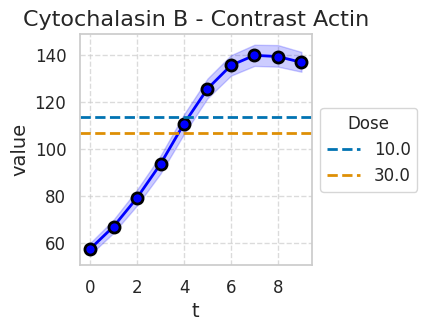

In [64]:
make_lineplot(dose_texture_features_cyto, interp_texture_features_cyto, "contrast_actin","Cytochalasin B - Contrast Actin")

Taxol

[(3.0, 76.96430383557245), (1.0, 69.37972404971055), (0.3, 67.41651589912574)]


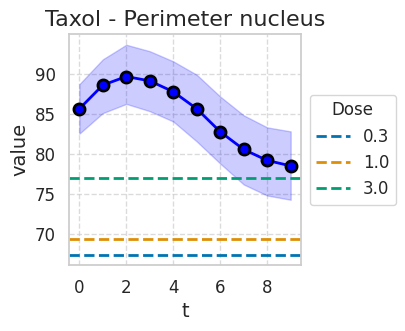

In [65]:
make_lineplot(dose_texture_features_taxol, interp_texture_features_taxol, "contrast_tubulin","Taxol - Perimeter nucleus")

Mevinolin

[(1.5, 0.6527283926560642), (15.0, 0.6184740788749137), (5.0, 0.6350994896969725)]


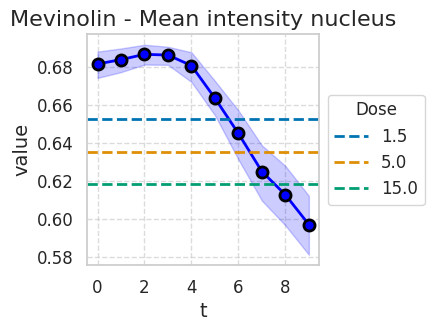

In [66]:
make_lineplot(dose_shape_features_mevin, interp_shape_features_mevin, "intensity_mean_nucleus","Mevinolin - Mean intensity nucleus")

Mitixantrone 

[(0.003, 115.92373622357361), (0.01, 105.5762061403526)]


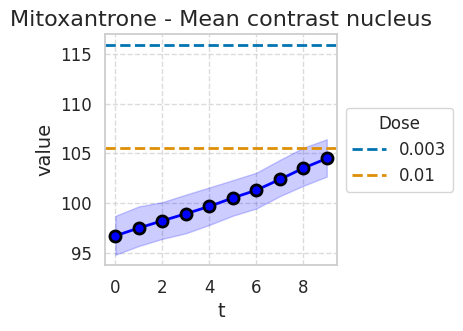

In [67]:
make_lineplot(dose_texture_features_mitox, interp_texture_features_mitox, "contrast_nucleus","Mitoxantrone - Mean contrast nucleus")

proteasome inhibitor

[(0.1, 62.506197645014204), (3.0, 78.48802966101834)]


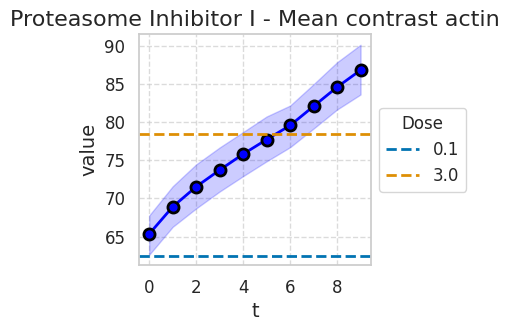

In [68]:
make_lineplot(dose_texture_features_prote, interp_texture_features_prote, "contrast_actin","Proteasome Inhibitor I - Mean contrast actin")

vincristine

[(0.3, 919.8070728291317), (0.03, 757.6023151154401), (0.003, 570.062319590132), (0.01, 761.8827695560253), (1.0, 767.8073066979317), (0.1, 858.580172001911), (3.0, 854.4660714285716)]


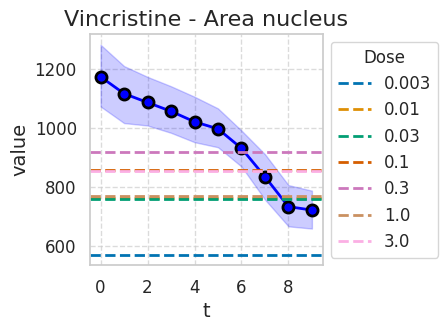

In [70]:
make_lineplot(dose_shape_features_vincristine, interp_shape_features_vincristine, "area_nucleus","Vincristine - Area nucleus")

In [102]:
# results_df = {"alpha": []}
# results_df["area_nucleus"] = []
# for dose in dose_shape_features_vincristine:
#     results_df["alpha"] += [dose for _ in range(len(dose_shape_features_vincristine[dose]["area_nucleus"]))]
#     results_df["area_nucleus"] += list(dose_shape_features_vincristine[dose]["area_nucleus"])

results_df = {"alpha": []}
results_df["contrast_actin"] = []
for dose in dose_texture_features_cyto:
    results_df["alpha"] += [dose for _ in range(len(dose_texture_features_cyto[dose]["contrast_actin"]))]
    results_df["contrast_actin"] += list(dose_texture_features_cyto[dose]["contrast_actin"])

In [103]:
pd.DataFrame(results_df).to_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/source_data/supplementary_figure_5b_cyto.csv")

In [79]:
def save_results_df(dict, fea):

IndentationError: expected an indented block (4267067200.py, line 1)

demecolcine

[(3.0, 799.2760088944873), (10.0, 736.5932726070226), (0.3, 771.6631172839506), (1.0, 908.9496178569707)]


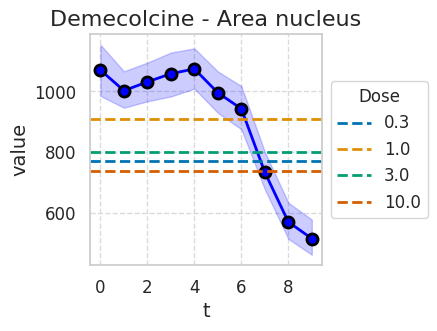

In [71]:
make_lineplot(dose_shape_features_demecolcine, interp_shape_features_demecolcine, "area_nucleus","Demecolcine - Area nucleus")

Save_stuff as pkl

In [72]:
import pickle as pkl 

In [73]:
dose_shape_features_all = [dose_shape_features_noco, 
                           dose_shape_features_cyto, 
                           dose_shape_features_taxol, 
                           dose_shape_features_AZ258, 
                           dose_shape_features_mevin, 
                           dose_shape_features_mitomy,
                           dose_shape_features_mitox,
                           dose_shape_features_prote, 
                           dose_shape_features_vincristine,
                           dose_shape_features_demecolcine, 
                          ]

dose_texture_features_all = [dose_texture_features_noco, 
                               dose_texture_features_cyto, 
                               dose_texture_features_taxol, 
                               dose_texture_features_AZ258, 
                               dose_texture_features_mevin, 
                               dose_texture_features_mitomy,
                               dose_texture_features_mitox,
                               dose_texture_features_prote, 
                               dose_texture_features_vincristine,
                               dose_texture_features_demecolcine]

interp_shape_features_all = [interp_shape_features_noco, 
                               interp_shape_features_cyto, 
                               interp_shape_features_taxol, 
                               interp_shape_features_AZ258, 
                               interp_shape_features_mevin, 
                               interp_shape_features_mitomy,
                               interp_shape_features_mitox,
                               interp_shape_features_prote, 
                               interp_shape_features_vincristine,
                               interp_shape_features_demecolcine]

interp_texture_features_all = [interp_texture_features_noco, 
                               interp_texture_features_cyto, 
                               interp_texture_features_taxol, 
                               interp_texture_features_AZ258, 
                               interp_texture_features_mevin, 
                               interp_texture_features_mitomy,
                               interp_texture_features_mitox,
                               interp_texture_features_prote, 
                               interp_texture_features_vincristine,
                               interp_texture_features_demecolcine]

In [ ]:
# import pickle as pkl

# with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/dose_shape_features_all.pkl", "wb") as file_dose_shape_features_all:
#     pkl.dump(dose_shape_features_all, file_dose_shape_features_all)

# with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/dose_texture_features_all.pkl", "wb") as file_dose_texture_features_all:
#     pkl.dump(dose_texture_features_all, file_dose_texture_features_all)

# with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/interp_shape_features_all.pkl", "wb") as file_interp_shape_features_all:
#     pkl.dump(interp_shape_features_all, file_interp_shape_features_all)

# with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/interp_texture_features_all.pkl", "wb") as file_interp_texture_features_all:
#     pkl.dump(interp_texture_features_all, file_interp_texture_features_all)

In [ ]:
import pickle as pkl

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/dose_shape_features_all.pkl", "rb") as file_dose_shape_features_all:
    dose_shape_features_all = pkl.load(file_dose_shape_features_all)

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/dose_texture_features_all.pkl", "rb") as file_dose_texture_features_all:
    dose_texture_features_all = pkl.load(file_dose_texture_features_all)

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/interp_shape_features_all.pkl", "rb") as file_interp_shape_features_all:
    interp_shape_features_all = pkl.load(file_interp_shape_features_all)

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/interp_texture_features_all.pkl", "rb") as file_interp_texture_features_all:
    interp_texture_features_all = pkl.load(file_interp_texture_features_all)

In [ ]:
(dose_shape_features_noco, 
 dose_shape_features_cyto, 
 dose_shape_features_taxol, 
 dose_shape_features_AZ258, 
 dose_shape_features_mevin, 
 dose_shape_features_mitomy,
 dose_shape_features_mitox,
 dose_shape_features_prote, 
 dose_shape_features_vincristine,
 dose_shape_features_demecolcine) = dose_shape_features_all

In [ ]:
(dose_texture_features_noco, 
    dose_texture_features_cyto, 
    dose_texture_features_taxol, 
    dose_texture_features_AZ258, 
    dose_texture_features_mevin, 
    dose_texture_features_mitomy,
    dose_texture_features_mitox,
    dose_texture_features_prote, 
    dose_texture_features_vincristine,
    dose_texture_features_demecolcine) = dose_texture_features_all

In [ ]:
(interp_shape_features_noco, 
   interp_shape_features_cyto, 
   interp_shape_features_taxol, 
   interp_shape_features_AZ258, 
   interp_shape_features_mevin, 
   interp_shape_features_mitomy,
   interp_shape_features_mitox,
   interp_shape_features_prote, 
   interp_shape_features_vincristine,
   interp_shape_features_demecolcine) = interp_shape_features_all

In [ ]:
(interp_texture_features_noco, 
   interp_texture_features_cyto, 
   interp_texture_features_taxol, 
   interp_texture_features_AZ258, 
   interp_texture_features_mevin, 
   interp_texture_features_mitomy,
   interp_texture_features_mitox,
   interp_texture_features_prote, 
   interp_texture_features_vincristine,
   interp_texture_features_demecolcine) = interp_texture_features_all